In [1]:
import pandas as pd
import emoji
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform, loguniform

### Funciones

In [2]:
def contador(text):
    aux = ' '.join(text)
    aux_min = re.sub(r'\W+',' ',aux.lower())
    contador = Counter(aux_min.split())
    return contador 

### Lectura de datos

In [3]:
df = pd.read_csv('sentiment.csv')

In [4]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Analisis de datos

In [5]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [6]:
df['sentiment'].value_counts()/len(df)

sentiment
positive    0.5
negative    0.5
Name: count, dtype: float64

In [7]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

### Ingenieria de Variables

In [8]:
df['Tam_Texto'] = df['review'].str.len() # Tamano del texto segun sus caracteres 

In [9]:
df['N_words'] = df['review'].str.split(' ').str.len() # Numero de palabras en la review 

In [10]:
df['N_caracteres_especiales'] = df['review'].apply(lambda x: sum(1 for c in x if not c.isalnum() and c != ' ')) # Nunmero de caracteres no 
# alfanumericos en la review

In [11]:
df['N_mayus'] = df['review'].apply(lambda x: sum(1 for c in x if c.isupper())) # Numero de mayusculas en review

In [12]:
df['Ratio_mayus'] = df['review'].apply(lambda x: sum(1 for c in x  if c.isupper())/len(x)) # Ratio de mayusculas en la review

In [13]:
df['N_dots'] = df['review'].str.split('.').str.len() - 1  # Numero de puntos en la review

In [14]:
df['N_minus'] = df['review'].apply(lambda x: sum(1 for c in x if c.islower())) # Numero de minusculas en la review

In [15]:
df['Ratio_minus'] = df['review'].apply(lambda x: sum(1 for c in x if c.islower()) / len(x)) # Ratio de minusculas

In [16]:
df['Ratio_mayus/palabras'] = df['Ratio_mayus'] / df['N_words'] # Ratio de mayusculas por palabra 

In [17]:
df.isnull().sum()

review                     0
sentiment                  0
Tam_Texto                  0
N_words                    0
N_caracteres_especiales    0
N_mayus                    0
Ratio_mayus                0
N_dots                     0
N_minus                    0
Ratio_minus                0
Ratio_mayus/palabras       0
dtype: int64

In [18]:
df['Ratio_minus/palabras'] = df['Ratio_minus'] / df['N_words'] # Ratio de minusculas por palabra 

In [19]:
df['N_caracteres_especiales/palabras'] = df['N_caracteres_especiales'] / df ['N_words'] # Caracteres especiales sobre numero de palabras

In [20]:
df.isnull().sum()

review                              0
sentiment                           0
Tam_Texto                           0
N_words                             0
N_caracteres_especiales             0
N_mayus                             0
Ratio_mayus                         0
N_dots                              0
N_minus                             0
Ratio_minus                         0
Ratio_mayus/palabras                0
Ratio_minus/palabras                0
N_caracteres_especiales/palabras    0
dtype: int64

In [21]:
df['Tam_Texto/palabras'] = df['Tam_Texto'] / df['N_words'] # Tamanio de ptexto sobre numero de palabras

In [22]:
len(df[df['review'].apply(lambda x: any(emoji.is_emoji(c) for c in x))])

5

In [23]:
df['Emoji'] = df['review'].apply(lambda x: any(emoji.is_emoji(c) for c in x)) # Si hay emoji en el texto

In [24]:
df[df['Emoji'] == True]

,review,sentiment,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,Ratio_minus/palabras,N_caracteres_especiales/palabras,Tam_Texto/palabras,Emoji
13735,I checked this movie out based on a favorable ...,negative,219,42,6,7,0.031963,4,165,0.753425,0.000761,0.017939,0.142857,5.214286,True
21141,"""In April 1946, the University of Chicago agre...",positive,2926,462,138,154,0.052632,31,2099,0.717362,0.000114,0.001553,0.298701,6.333333,True
22728,That's the sound of Stan and Ollie spinning in...,negative,3360,597,153,90,0.026786,28,2518,0.749405,0.000045,0.001255,0.256281,5.628141,True
36507,Klatret©ªsen(Catch That Girl) is really great ...,positive,292,47,27,23,0.078767,4,190,0.650685,0.001676,0.013844,0.574468,6.212766,True
46515,I chuckled a few times during this movie. I la...,negative,2654,466,126,89,0.033534,45,1974,0.743783,0.000072,0.001596,0.270386,5.695279,True


In [25]:
df['Exclamacion'] = df['review'].apply(lambda x: '!'  in str(x)) # Si tiene signos de exclamacion

In [26]:
df['Interrogacion'] = df['review'].apply(lambda x: '?' in str(x)) # Si tiene signos de interrogacion

In [27]:
df['Puntos_suspensivos'] = df['review'].str.contains(r'\.\.\.')  # Si tiene puntos suspensivos

In [28]:
len(df['review'].unique())

49582

In [29]:
df

,review,sentiment,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,Ratio_minus/palabras,N_caracteres_especiales/palabras,Tam_Texto/palabras,Emoji,Exclamacion,Interrogacion,Puntos_suspensivos
0,One of the other reviewers has mentioned that ...,positive,1761,307,78,43,0.024418,26,1333,0.756956,0.000080,0.002466,0.254072,5.736156,False,False,False,True
1,A wonderful little production. <br /><br />The...,positive,998,162,44,16,0.016032,6,777,0.778557,0.000099,0.004806,0.271605,6.160494,False,True,False,False
2,I thought this was a wonderful way to spend ti...,positive,926,166,40,23,0.024838,6,697,0.752700,0.000150,0.004534,0.240964,5.578313,False,False,True,False
3,Basically there's a family where a little boy ...,negative,748,138,42,24,0.032086,10,542,0.724599,0.000233,0.005251,0.304348,5.420290,False,True,False,True
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,230,56,34,0.025816,15,998,0.757783,0.000112,0.003295,0.243478,5.726087,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1008,194,46,14,0.013889,8,750,0.744048,0.000072,0.003835,0.237113,5.195876,False,False,False,False
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,642,112,26,19,0.029595,5,486,0.757009,0.000264,0.006759,0.232143,5.732143,False,False,False,False
49997,I am a Catholic taught in parochial elementary...,negative,1280,230,45,22,0.017188,17,984,0.768750,0.000075,0.003342,0.195652,5.565217,False,False,False,True
49998,I'm going to have to disagree with the previou...,negative,1234,212,28,23,0.018639,8,970,0.786062,0.000088,0.003708,0.132075,5.820755,False,False,False,False


In [30]:
pd.set_option('display.max_colwidth', None) # Reviews duplicados
df[df.duplicated('review', keep = False)]

,review,sentiment,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,Ratio_minus/palabras,N_caracteres_especiales/palabras,Tam_Texto/palabras,Emoji,Exclamacion,Interrogacion,Puntos_suspensivos
42,"Of all the films I have seen, this one, The Rage, has got to be one of the worst yet. The direction, LOGIC, continuity, changes in plot-script and dialog made me cry out in pain. ""How could ANYONE come up with something so crappy""? Gary Busey is know for his ""B"" movies, but this is a sure ""W"" movie. (W=waste).<br /><br />Take for example: about two dozen FBI & local law officers surround a trailer house with a jeep wagoneer. Inside the jeep is MA and is ""confused"" as to why all the cops are about. Within seconds a huge gun battle ensues, MA being killed straight off. The cops blast away at the jeep with gary and company blasting away at them. The cops fall like dominoes and the jeep with Gary drives around in circles and are not hit by one single bullet/pellet. MA is killed and gary seems to not to have noticed-damn that guy is tough. Truly a miracle, not since the six-shooter held 300 bullets has there been such a miracle.",negative,937,176,44,38,0.040555,11,677,0.722519,0.000230,0.004105,0.250000,5.323864,False,False,True,False
84,"We brought this film as a joke for a friend, and could of been our worst joke to play. The film is barely watchable, and the acting is dire. The worst child actor ever used and Hasslehoff giving a substandard performance. The plot is disgraceful and at points we was so bored we was wondering what the hell was going on. It tries to be gruesome in places but is just laughable.<br /><br />Just terrible",negative,402,75,13,7,0.017413,5,308,0.766169,0.000232,0.010216,0.173333,5.360000,False,False,False,False
140,"Before I begin, let me get something off my chest: I'm a huge fan of John Eyres' first film PROJECT: SHADOWCHASER. The film, a B-grade cross of both THE TERMINATOR & DIE HARD, may not be the work of a cinematic genius, but is a hugely entertaining action film that became a cult hit (& spawned two sequels & a spin off).<br /><br />Judge and Jury begins with Joseph Meeker, a convicted killer who was sent to Death Row following his capture after the so-called ""Bloody Shootout"" (which seems like a poor name for a killing spree  Meeker kills three people while trying to rob a convenience store), being led to the electric chair. There is an amusing scene where Meeker talks to the priest about living for sex but meeting his one true love (who was killed during the shootout), expressing his revenge for the person who killed her  Michael Silvano, a washed-up football star who spends his days watching his son Alex practicing football with his high school team (and ends up harassing his son's coach). But once executed, Meeker returns as a revenant (or as Kelly Perine calls ""a hamburger without the fries""), whose sole aim is to get his revenge, which basically means making Silvano's life a misery.<br /><br />Let me point out the fact that Judge and Jury is not a true horror film. It is a supernatural action film, with Meeker chasing Silvano, using his ability to change form (which amounts to David Keith dressing up as everything from an Elvis impersonator, a French chef (with an accent as bad as his moustache), a drag queen, a clown & a stand-up comedian), a shotgun which fires explosive rounds & an invulnerability to death (although that doesn't stop Martin Kove from shooting Keith with a Desert Eagle), to pay Silvano back for killing Meeker's wife.<br /><br />Director John Eyres does not seem interested in characterisations, instead focusing solely on action scenes, which the film has plenty of. But that is the film's main flaw, since there's nothing to connect the action scenes together. The acting is surprisingly good, with Keith delivering the best performance, supported ably by Kove, as well as Paul Koslo, who plays the washed-up cop 

In [31]:
pd.reset_option('display.max_colwidth')

In [32]:
df

,review,sentiment,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,Ratio_minus/palabras,N_caracteres_especiales/palabras,Tam_Texto/palabras,Emoji,Exclamacion,Interrogacion,Puntos_suspensivos
0,One of the other reviewers has mentioned that ...,positive,1761,307,78,43,0.024418,26,1333,0.756956,0.000080,0.002466,0.254072,5.736156,False,False,False,True
1,A wonderful little production. <br /><br />The...,positive,998,162,44,16,0.016032,6,777,0.778557,0.000099,0.004806,0.271605,6.160494,False,True,False,False
2,I thought this was a wonderful way to spend ti...,positive,926,166,40,23,0.024838,6,697,0.752700,0.000150,0.004534,0.240964,5.578313,False,False,True,False
3,Basically there's a family where a little boy ...,negative,748,138,42,24,0.032086,10,542,0.724599,0.000233,0.005251,0.304348,5.420290,False,True,False,True
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,230,56,34,0.025816,15,998,0.757783,0.000112,0.003295,0.243478,5.726087,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1008,194,46,14,0.013889,8,750,0.744048,0.000072,0.003835,0.237113,5.195876,False,False,False,False
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,642,112,26,19,0.029595,5,486,0.757009,0.000264,0.006759,0.232143,5.732143,False,False,False,False
49997,I am a Catholic taught in parochial elementary...,negative,1280,230,45,22,0.017188,17,984,0.768750,0.000075,0.003342,0.195652,5.565217,False,False,False,True
49998,I'm going to have to disagree with the previou...,negative,1234,212,28,23,0.018639,8,970,0.786062,0.000088,0.003708,0.132075,5.820755,False,False,False,False


In [33]:
df_sin_dup = df.drop_duplicates(subset = 'review', keep = 'first')

In [34]:
df_sin_dup # Nos quedamos con las reviews no repetidas

,review,sentiment,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,Ratio_minus/palabras,N_caracteres_especiales/palabras,Tam_Texto/palabras,Emoji,Exclamacion,Interrogacion,Puntos_suspensivos
0,One of the other reviewers has mentioned that ...,positive,1761,307,78,43,0.024418,26,1333,0.756956,0.000080,0.002466,0.254072,5.736156,False,False,False,True
1,A wonderful little production. <br /><br />The...,positive,998,162,44,16,0.016032,6,777,0.778557,0.000099,0.004806,0.271605,6.160494,False,True,False,False
2,I thought this was a wonderful way to spend ti...,positive,926,166,40,23,0.024838,6,697,0.752700,0.000150,0.004534,0.240964,5.578313,False,False,True,False
3,Basically there's a family where a little boy ...,negative,748,138,42,24,0.032086,10,542,0.724599,0.000233,0.005251,0.304348,5.420290,False,True,False,True
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,230,56,34,0.025816,15,998,0.757783,0.000112,0.003295,0.243478,5.726087,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1008,194,46,14,0.013889,8,750,0.744048,0.000072,0.003835,0.237113,5.195876,False,False,False,False
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,642,112,26,19,0.029595,5,486,0.757009,0.000264,0.006759,0.232143,5.732143,False,False,False,False
49997,I am a Catholic taught in parochial elementary...,negative,1280,230,45,22,0.017188,17,984,0.768750,0.000075,0.003342,0.195652,5.565217,False,False,False,True
49998,I'm going to have to disagree with the previou...,negative,1234,212,28,23,0.018639,8,970,0.786062,0.000088,0.003708,0.132075,5.820755,False,False,False,False


In [35]:
df_sin_dup['sentiment'].value_counts()/len(df_sin_dup)

sentiment
positive    0.501876
negative    0.498124
Name: count, dtype: float64

In [36]:
df_vec = df_sin_dup.copy()

In [37]:
df_vec['review'] = df_vec['review'].str.lower() # TfidfVectorizer funciona mejor con minusculas

In [38]:
df_vec

,review,sentiment,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,Ratio_minus/palabras,N_caracteres_especiales/palabras,Tam_Texto/palabras,Emoji,Exclamacion,Interrogacion,Puntos_suspensivos
0,one of the other reviewers has mentioned that ...,positive,1761,307,78,43,0.024418,26,1333,0.756956,0.000080,0.002466,0.254072,5.736156,False,False,False,True
1,a wonderful little production. <br /><br />the...,positive,998,162,44,16,0.016032,6,777,0.778557,0.000099,0.004806,0.271605,6.160494,False,True,False,False
2,i thought this was a wonderful way to spend ti...,positive,926,166,40,23,0.024838,6,697,0.752700,0.000150,0.004534,0.240964,5.578313,False,False,True,False
3,basically there's a family where a little boy ...,negative,748,138,42,24,0.032086,10,542,0.724599,0.000233,0.005251,0.304348,5.420290,False,True,False,True
4,"petter mattei's ""love in the time of money"" is...",positive,1317,230,56,34,0.025816,15,998,0.757783,0.000112,0.003295,0.243478,5.726087,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,i thought this movie did a down right good job...,positive,1008,194,46,14,0.013889,8,750,0.744048,0.000072,0.003835,0.237113,5.195876,False,False,False,False
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative,642,112,26,19,0.029595,5,486,0.757009,0.000264,0.006759,0.232143,5.732143,False,False,False,False
49997,i am a catholic taught in parochial elementary...,negative,1280,230,45,22,0.017188,17,984,0.768750,0.000075,0.003342,0.195652,5.565217,False,False,False,True
49998,i'm going to have to disagree with the previou...,negative,1234,212,28,23,0.018639,8,970,0.786062,0.000088,0.003708,0.132075,5.820755,False,False,False,False


In [39]:
df_vec = pd.get_dummies(df_vec, columns  = ['Emoji', 'Exclamacion','Interrogacion','Puntos_suspensivos']) # Convertimos a dummies las categoricas 

In [40]:
le = LabelEncoder()

In [41]:
df_vec['sentiment'] = le.fit_transform(df_vec['sentiment']) # 1 Positive, 0 negative

In [42]:
df_vec.dtypes

review                               object
sentiment                             int64
Tam_Texto                             int64
N_words                               int64
N_caracteres_especiales               int64
N_mayus                               int64
Ratio_mayus                         float64
N_dots                                int64
N_minus                               int64
Ratio_minus                         float64
Ratio_mayus/palabras                float64
Ratio_minus/palabras                float64
N_caracteres_especiales/palabras    float64
Tam_Texto/palabras                  float64
Emoji_False                            bool
Emoji_True                             bool
Exclamacion_False                      bool
Exclamacion_True                       bool
Interrogacion_False                    bool
Interrogacion_True                     bool
Puntos_suspensivos_False               bool
Puntos_suspensivos_True                bool
dtype: object

In [43]:
lst_cont = df_vec.select_dtypes(include = ['float64', 'int64']).columns

In [44]:
lst_cont = lst_cont[lst_cont != 'sentiment']

In [45]:
lst_cont

Index(['Tam_Texto', 'N_words', 'N_caracteres_especiales', 'N_mayus',
       'Ratio_mayus', 'N_dots', 'N_minus', 'Ratio_minus',
       'Ratio_mayus/palabras', 'Ratio_minus/palabras',
       'N_caracteres_especiales/palabras', 'Tam_Texto/palabras'],
      dtype='object')

In [46]:
df_vec

,review,sentiment,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,...,N_caracteres_especiales/palabras,Tam_Texto/palabras,Emoji_False,Emoji_True,Exclamacion_False,Exclamacion_True,Interrogacion_False,Interrogacion_True,Puntos_suspensivos_False,Puntos_suspensivos_True
0,one of the other reviewers has mentioned that ...,1,1761,307,78,43,0.024418,26,1333,0.756956,...,0.254072,5.736156,True,False,True,False,True,False,False,True
1,a wonderful little production. <br /><br />the...,1,998,162,44,16,0.016032,6,777,0.778557,...,0.271605,6.160494,True,False,False,True,True,False,True,False
2,i thought this was a wonderful way to spend ti...,1,926,166,40,23,0.024838,6,697,0.752700,...,0.240964,5.578313,True,False,True,False,False,True,True,False
3,basically there's a family where a little boy ...,0,748,138,42,24,0.032086,10,542,0.724599,...,0.304348,5.420290,True,False,False,True,True,False,False,True
4,"petter mattei's ""love in the time of money"" is...",1,1317,230,56,34,0.025816,15,998,0.757783,...,0.243478,5.726087,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,i thought this movie did a down right good job...,1,1008,194,46,14,0.013889,8,750,0.744048,...,0.237113,5.195876,True,False,True,False,True,False,True,False
49996,"bad plot, bad dialogue, bad acting, idiotic di...",0,642,112,26,19,0.029595,5,486,0.757009,...,0.232143,5.732143,True,False,True,False,True,False,True,False
49997,i am a catholic taught in parochial elementary...,0,1280,230,45,22,0.017188,17,984,0.768750,...,0.195652,5.565217,True,False,True,False,True,False,False,True
49998,i'm going to have to disagree with the previou...,0,1234,212,28,23,0.018639,8,970,0.786062,...,0.132075,5.820755,True,False,True,False,True,False,True,False


In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_vec.drop(columns='sentiment'),df_vec['sentiment'],test_size=0.3, random_state=666)

In [48]:
X_train

,review,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,...,N_caracteres_especiales/palabras,Tam_Texto/palabras,Emoji_False,Emoji_True,Exclamacion_False,Exclamacion_True,Interrogacion_False,Interrogacion_True,Puntos_suspensivos_False,Puntos_suspensivos_True
17805,"hugh (ed harris) is a hotshot, bachelor senato...",1026,176,30,23,0.022417,11,798,0.777778,0.000127,...,0.170455,5.829545,True,False,True,False,False,True,True,False
2002,i love playing football and i thought this mov...,786,141,18,31,0.039440,8,595,0.756997,0.000280,...,0.127660,5.574468,True,False,True,False,True,False,True,False
14615,"perhaps the biggest waste of production time, ...",212,35,9,3,0.014151,3,166,0.783019,0.000404,...,0.257143,6.057143,True,False,True,False,True,False,True,False
11146,at first i didn't like the movie cause of it b...,3856,703,92,125,0.032417,47,2921,0.757521,0.000046,...,0.130868,5.485064,True,False,True,False,False,True,True,False
32869,naturally i didn't watch 'gi jane' out of choi...,1023,169,51,26,0.025415,9,772,0.754643,0.000150,...,0.301775,6.053254,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43730,humour is a very individual thing and the audi...,481,90,7,14,0.029106,4,363,0.754678,0.000323,...,0.077778,5.344444,True,False,True,False,True,False,True,False
41308,this one is a little better than the first one...,356,65,12,7,0.019663,6,273,0.766854,0.000303,...,0.184615,5.476923,True,False,True,False,True,False,True,False
2878,the 1978 adaptation had all the ingredients of...,2216,383,57,69,0.031137,16,1701,0.767599,0.000081,...,0.148825,5.785901,True,False,True,False,True,False,True,False
40639,this is what happens when you try to adapt a p...,770,134,39,14,0.018182,7,584,0.758442,0.000136,...,0.291045,5.746269,True,False,True,False,False,True,True,False


In [49]:
y_train

17805    1
2002     1
14615    0
11146    1
32869    0
        ..
43730    0
41308    0
2878     1
40639    0
10132    1
Name: sentiment, Length: 34707, dtype: int64

In [50]:
sc = StandardScaler()

In [51]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

In [52]:
X_train[lst_cont] = sc.fit_transform(X_train[lst_cont])

In [53]:
X_train_v = vectorizer.fit_transform(X_train['review']) # Vectorizamos nuesto df

In [54]:
X_test[lst_cont] = sc.transform(X_test[lst_cont])

In [55]:
X_test_v = vectorizer.transform(X_test['review']) # Vectorizamos nuesto df

In [56]:
X_test[lst_cont].describe()

,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,Ratio_minus/palabras,N_caracteres_especiales/palabras,Tam_Texto/palabras
count,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000
mean,0.002399,0.002757,0.004773,-0.000258,-0.003154,0.023173,0.002299,0.003594,0.001634,-0.006927,-0.002562,0.001361
std,0.991121,0.992869,1.001510,0.985849,0.954009,1.043915,0.989520,1.016120,1.148915,1.061291,0.994501,0.996360
min,-1.267218,-1.321750,-1.172195,-1.047437,-1.771499,-1.325489,-1.253879,-24.528678,-0.875878,-1.256595,-2.358770,-9.960340
25%,-0.612899,-0.606180,-0.650468,-0.578914,-0.567550,-0.608976,-0.610363,-0.492777,-0.515592,-0.613846,-0.664098,-0.635571
50%,-0.335065,-0.332751,-0.287528,-0.286087,-0.184767,-0.301898,-0.333625,0.124748,-0.252754,-0.168610,-0.136150,-0.037787
75%,0.282008,0.289736,0.347618,0.241002,0.327197,0.312256,0.284733,0.657486,0.152894,0.265722,0.483764,0.599883
max,12.476499,13.024549,11.122414,20.153250,11.216391,16.075553,12.183156,2.754411,68.099801,54.309009,14.714360,20.857010


In [57]:
X_train[lst_cont].describe()

,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,Ratio_minus/palabras,N_caracteres_especiales/palabras,Tam_Texto/palabras
count,3.470700e+04,3.470700e+04,3.470700e+04,3.470700e+04,3.470700e+04,3.470700e+04,3.470700e+04,3.470700e+04,3.470700e+04,3.470700e+04,3.470700e+04,3.470700e+04
mean,-1.120875e-16,5.102797e-17,3.106718e-17,4.503973e-17,-6.264617e-17,-2.692148e-17,-8.342587e-17,3.403366e-15,-5.036261e-17,2.563170e-16,-1.965370e-16,-1.044922e-15
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-1.286344e+00,-1.310115e+00,-1.194879e+00,-1.047437e+00,-1.771499e+00,-1.325489e+00,-1.308167e+00,-2.915217e+01,-8.758775e-01,-1.337954e+00,-2.429788e+00,-3.566121e+00
25%,-6.159188e-01,-6.119978e-01,-6.504684e-01,-5.789139e-01,-5.675503e-01,-6.089756e-01,-6.143353e-01,-4.985519e-01,-5.121477e-01,-6.127512e-01,-6.676914e-01,-6.584358e-01
50%,-3.431182e-01,-3.385688e-01,-3.102117e-01,-2.860868e-01,-1.739848e-01,-3.018983e-01,-3.442175e-01,1.149317e-01,-2.413536e-01,-1.629695e-01,-1.339529e-01,-3.970352e-02
75%,2.840213e-01,2.839186e-01,3.249342e-01,2.410022e-01,3.351905e-01,3.122561e-01,2.794368e-01,6.416218e-01,1.730752e-01,2.709907e-01,4.908824e-01,6.119516e-01
max,1.175574e+01,1.190756e+01,1.370837e+01,2.088532e+01,4.900766e+01,1.658735e+01,1.194879e+01,2.872148e+00,3.279175e+01,3.244770e+01,2.674928e+01,2.238924e+01


In [58]:
tf_train_df = pd.DataFrame(
    X_train_v.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index = X_train.index
) 

In [59]:
tf_test_df = pd.DataFrame(
    X_test_v.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index = X_test.index
) 

In [60]:
X_train_f = pd.concat([X_train.reset_index(drop=True), tf_train_df.reset_index(drop=True)], axis = True)
X_test_f = pd.concat([X_test.reset_index(drop=True), tf_test_df.reset_index(drop=True)], axis = True)

In [61]:
X_train_f

,review,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,...,wrong,wrote,yeah,year,years,yes,york,young,younger,zombie
0,"hugh (ed harris) is a hotshot, bachelor senato...",-0.285739,-0.321116,-0.514366,-0.373935,-0.341076,-0.199539,-0.251530,0.981823,-0.278467,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,i love playing football and i thought this mov...,-0.527334,-0.524733,-0.786571,-0.139673,0.745152,-0.506616,-0.520324,0.176716,0.436096,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,"perhaps the biggest waste of production time, ...",-1.105148,-1.141403,-0.990725,-0.959589,-0.868538,-1.018412,-1.088365,1.184882,1.020489,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,at first i didn't like the movie cause of it b...,2.563064,2.744780,0.892029,2.612902,0.297007,3.485387,2.559549,0.196991,-0.659594,...,0.0,0.0,0.0,0.053658,0.0,0.0,0.0,0.000000,0.0,0.0
4,naturally i didn't watch 'gi jane' out of choi...,-0.288759,-0.361839,-0.038006,-0.286087,-0.149758,-0.404257,-0.285957,0.085504,-0.170509,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34702,humour is a very individual thing and the audi...,-0.834361,-0.821433,-1.036093,-0.637479,0.085736,-0.916053,-0.827516,0.086843,0.640982,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
34703,this one is a little better than the first one...,-0.960191,-0.966874,-0.922674,-0.842458,-0.516822,-0.711335,-0.946686,0.558593,0.542983,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
34704,the 1978 adaptation had all the ingredients of...,0.912167,0.883136,0.098096,0.973070,0.215342,0.312256,0.944138,0.587470,-0.494561,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
34705,this is what happens when you try to adapt a p...,-0.543440,-0.565457,-0.310212,-0.637479,-0.611330,-0.608976,-0.534889,0.232666,-0.239467,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.109437,0.0,0.0


In [62]:
X_test_f

,review,Tam_Texto,N_words,N_caracteres_especiales,N_mayus,Ratio_mayus,N_dots,N_minus,Ratio_minus,Ratio_mayus/palabras,...,wrong,wrote,yeah,year,years,yes,york,young,younger,zombie
0,my mom and i went to the ft worth premiere mai...,-0.536394,-0.507280,-0.514366,-0.110390,0.856425,-0.711335,-0.552102,-0.680284,0.465563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"this movie has wild bill hickok, calamity jane...",-0.543440,-0.530551,-0.899990,0.211719,1.791877,-0.506616,-0.546806,-0.220182,0.995040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ronald colman gives an electrifying performanc...,0.069606,-0.059322,0.551772,0.768091,1.097374,2.666515,0.037125,-0.607134,0.078324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"in spite of its high-minded ambitions, zurlini...",-0.568607,-0.606180,-0.673152,-0.725328,-0.829349,-0.813694,-0.533565,1.270740,-0.330575,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,for those of you who have read rohinton mistry...,0.008201,0.051213,-0.083374,-0.022542,-0.077019,-0.199539,0.004023,-0.020901,-0.356903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14870,it's one of those dramas that's so bad that it...,-0.645112,-0.641086,-0.854622,-0.930307,-1.389979,-0.916053,-0.606391,1.541648,-0.644110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14871,"when i saw this movie at age 6, it was in the ...",-0.970258,-0.972691,-1.013409,-0.461783,1.916899,-1.120771,-0.971844,-0.710259,3.360345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14872,director michael ritchie and actor robert redf...,-0.351171,-0.437469,-0.400947,-0.520349,-0.576320,-0.608976,-0.311115,1.205801,-0.312721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14873,"i must admit, at first i was worried about far...",-0.002872,-0.100046,-0.242160,-0.051825,-0.111579,-0.608976,0.039773,1.024641,-0.305721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modelo Regresion logistica

In [63]:
selector = SelectKBest(score_func = f_classif, k = 1000)

In [64]:
X_sel = selector.fit_transform(X_train_f.drop(columns = 'review'),y_train)

In [65]:
X_test_sel = selector.transform(X_test_f.drop(columns = 'review'))

In [66]:
logreg = LogisticRegression()

In [67]:
logreg.fit(X_sel, y_train)

/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [68]:
cv = cross_val_score(logreg, X_sel, y_train, cv = 5, scoring = 'roc_auc')

/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

In [69]:
print(cv)
print("ROC: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

[0.94035105 0.9367477  0.93482921 0.9363584  0.93343536]
ROC: 0.94 (+/- 0.00)


In [70]:
y_pred = logreg.predict(X_test_sel)
score = roc_auc_score(y_test, y_pred)
print('Score con datos no vistos:',score)

Score con datos no vistos: 0.862893414189497


### Modelo LDA

In [71]:
LDA = LinearDiscriminantAnalysis()

In [72]:
LDA.fit(X_sel, y_train)

LinearDiscriminantAnalysis()

In [73]:
cv_LDA = cross_val_score(LDA, X_sel, y_train, cv = 5, scoring = 'roc_auc')

In [74]:
print(cv_LDA)
print("ROC: %0.2f (+/- %0.2f)" % (cv_LDA.mean(), cv_LDA.std() * 2))

[0.93566292 0.93346515 0.93107745 0.93206746 0.92913885]
ROC: 0.93 (+/- 0.00)


In [75]:
y_pred = LDA.predict(X_test_sel)
score = roc_auc_score(y_test, y_pred)
print('Score con datos no vistos:',score)

Score con datos no vistos: 0.8571846356408568


### Modelo con Arbol

In [76]:
tree = DecisionTreeClassifier()

In [77]:
tree.fit(X_sel, y_train)

DecisionTreeClassifier()

In [78]:
cv_tree = cross_val_score(tree, X_sel, y_train, cv = 5, scoring = 'roc_auc')

In [79]:
print(cv_tree)
print("ROC: %0.2f (+/- %0.2f)" % (cv_tree.mean(), cv_tree.std() * 2))

[0.71049718 0.70095193 0.7073907  0.69928835 0.70653937]
ROC: 0.70 (+/- 0.01)


In [80]:
y_pred = tree.predict(X_test_sel)
score = roc_auc_score(y_test, y_pred)
print('Score con datos no vistos:',score)

Score con datos no vistos: 0.7066405656555426


### Modelo con Red Neuronal

In [81]:
mlp = MLPClassifier()

In [82]:
mlp.fit(X_sel, y_train)

MLPClassifier()

In [83]:
cv_mlp = cross_val_score(tree, X_sel, y_train, cv = 5, scoring = 'roc_auc', n_jobs=-1)

In [84]:
print(cv_mlp)
print("ROC: %0.2f (+/- %0.2f)" % (cv_mlp.mean(), cv_mlp.std() * 2))

[0.71250852 0.70311866 0.70807838 0.70043367 0.71072479]
ROC: 0.71 (+/- 0.01)


In [85]:
y_pred = mlp.predict(X_test_sel)
score = roc_auc_score(y_test, y_pred)
print('Score con datos no vistos:',score)

Score con datos no vistos: 0.842543804122145


### Mejor modelo con hiperparametros

In [86]:
params = {
    'C': loguniform(1e-3, 1e2),  # rango más pequeño para menos combinaciones
    'penalty': ['l2', 'l1'],     # quitamos elasticnet para simplificar
    'solver': ['lbfgs', 'saga'], # 'lbfgs' para l2, 'saga' para l1 y l2
    'max_iter': [200, 500],      # reducimos opciones
    'class_weight': [None, 'balanced']
}


In [87]:
log_reg_hyper = LogisticRegression()

In [88]:
Log_reg_search = RandomizedSearchCV(estimator= log_reg_hyper,param_distributions=params,n_iter=5, cv=3, scoring='roc_auc', random_state=666, n_jobs=-1,verbose=1)

In [89]:
Log_reg_search.fit(X_sel,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x72546ddd65a0>,
                                        'class_weight': [None, 'balanced'],
                                        'max_iter': [200, 500],
                                        'penalty': ['l2', 'l1'],
                                        'solver': ['lbfgs', 'saga']},
                   random_state=666, scoring='roc_auc', verbose=1)

In [90]:
best = Log_reg_search.best_estimator_

In [91]:
Log_reg_search.best_params_

{'C': np.float64(3.1782320970231233),
 'class_weight': 'balanced',
 'max_iter': 200,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [92]:
cv_best = cross_val_score(best, X_sel, y_train, cv = 5, scoring = 'roc_auc', n_jobs=-1)

In [93]:
print(cv_best)
print("ROC: %0.2f (+/- %0.2f)" % (cv_best.mean(), cv_best.std() * 2))

[0.93990698 0.93617987 0.93382316 0.93634462 0.93285616]
ROC: 0.94 (+/- 0.00)


In [94]:
y_pred = best.predict(X_test_sel)
score = roc_auc_score(y_test, y_pred)
print('Score con datos no vistos:',score)

Score con datos no vistos: 0.8640470704410796


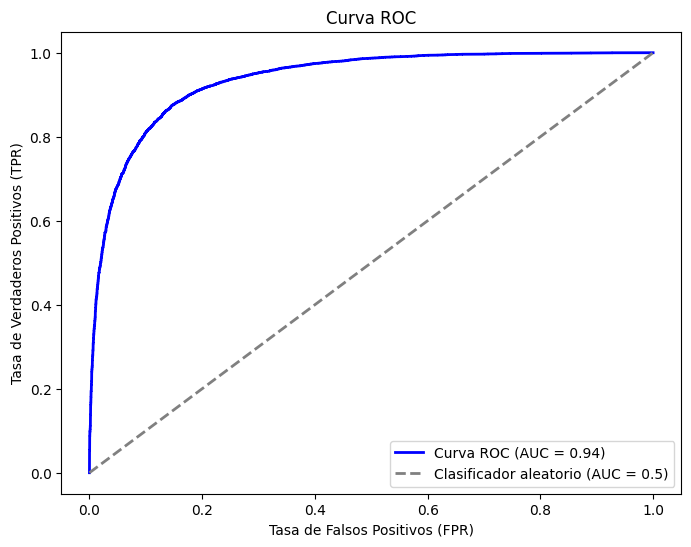

In [95]:
y_score = best.predict_proba(X_test_sel)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()